# Mnist Drawing AI
## Version 1.0
Das Ziel dieser AI ist es einmal ein funktionierendes Environnment zu kreieren,
in der die KI lernen und arbeiten kann.

Hierbei soll wenigstens geschaut werden, ob die AI es erlernt mal nur ein Bild
zu zeichnen. In einer späteren Version sollen erst dann mehrere Bilder
hineingegeben werden.

Dabei soll als Input dienen:
- Ziel Bild 28x28 -> np.shape = (784,)
- States
    - Canvas State 28x28 -> np.shape = (784,)
    - Position von Agent in Space (Pen Position) -> np.shape(2,)

Dabei soll der Output sein:
- Integer
    - Es wird immer 1, 2, 3, 4 Gezählt, welches die Himmelsrichtungen darstellt.
    - Eine erhöhter Wert wird in den Stroke in die Länge gehen -> Bsp. 8 -> 2 Mal nach Links (Direction 4 und Length 2)

## Importing

In [1]:
import abc
import tensorflow as tf
import numpy as np
import random

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import utils

import reverb

In [2]:
import matplotlib.pyplot as plt

In [3]:
from environnment import Canvas

## Env, Model and Agent Creation

### Load Dataset

In [4]:
from keras.datasets import mnist

In [5]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [6]:
env_py = Canvas(train_X[0])
env = tf_py_environment.TFPyEnvironment(env_py)

### Model

In [7]:
fc_layer_params = (100, 50) # Die Anzahl der Dense Units in einem Layer
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
print("Num Actions: ", num_actions)

# Helper function um die Dense Layer zu kreeieren.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# Create the dense layer array
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

# Create the output layer
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

# Sequentialize the layers into a tensorflow model
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Num Actions:  16


### Agent

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2022-04-18 23:00:16.259634: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (100)
2022-04-18 23:00:16.259684: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-ORA727V): /proc/driver/nvidia/version does not exist
2022-04-18 23:00:16.263670: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Random Metrics

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_return += episode_return

    avg_return = total_return / num_episodes
    env_py.render()
    return avg_return.numpy()[0]

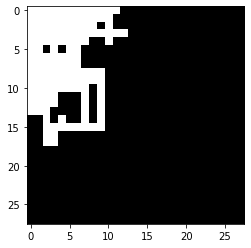

4322.5

In [10]:
compute_avg_return(env,
                   random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                   env.action_spec()),
                   10)

## Replay Buffer

In [11]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=100000,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmplh5d769t.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmplh5d769t
[reverb/cc/platform/default/server.cc:71] Started replay server on port 19448


### Testing the replay buffer

In [12]:
py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                        env.action_spec()),
        use_tf_function=True),
        [rb_observer],
        max_steps=100
    ).run(env_py.reset())

(TimeStep(
 {'discount': array(0.5, dtype=float32),
  'observation': array([0, 0, 0, ..., 0, 1, 8], dtype=int32),
  'reward': array(0., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [13]:
iter(replay_buffer.as_dataset()).next()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5987) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([14,  5], dtype=int32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5, 0.5], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 1570), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 6, 4],
        [0, 0, 0, ..., 0, 2, 4]], dtype=int32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([11999356933553309685, 11999356933553309685], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>))

In [14]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

In [15]:
iterator = iter(dataset)
print(iterator)

In [16]:
next(iterator)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5987) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5987) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5987) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5987) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (5987) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[ 1,  2],
        [10,  7],
        [ 0,  9],
        [12,  9],
        [ 5,  4],
        [10,  6],
        [ 9, 10],
        [ 9,  2],
        [ 1, 10],
        [ 9,  2],
        [ 3,  7],
        [ 4, 15],
        [10,  7],
        [13, 12],
        [ 2,  2],
        [13, 13],
        [15, 11],
        [ 5,  4],
        [ 9,  6],
        [ 3,  7],
        [15,  5],
        [ 5,  4],
        [10,  1],
        [15, 12],
        [10, 14],
        [11,  3],
        [ 7,  2],
        [ 2,  4],
        [11, 10],
        [13,  1],
        [ 4, 12],
        [ 6,  0],
        [ 2,  4],
        [ 6,  0],
        [ 7, 15],
        [12,  9],
        [ 1, 12],
        [ 8,  1],
        [ 2,  0],
        [ 7,  5],
        [ 9,  2],
        [ 2, 10],
        [ 9, 10],
        [11,  2],
        [ 3, 15],
        [ 3,  7],
        [10,  2],
        [ 2,  4],
        [11,  5],
        [11,  2],
        [15,  7],
        [1

## AI Training

In [17]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [18]:
time_step = env_py.reset()

In [19]:
# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=1)

step = 1010: loss = 0.3317280113697052
step = 1020: loss = 0.16932597756385803
step = 1030: loss = 0.31836578249931335
step = 1040: loss = 0.19487333297729492
step = 1050: loss = 0.23552611470222473
step = 1060: loss = 0.23106147348880768
step = 1070: loss = 0.48505115509033203
step = 1080: loss = 0.14498686790466309
step = 1090: loss = 0.08342482149600983
step = 1100: loss = 0.11105123907327652
step = 1110: loss = 0.4862176477909088
step = 1120: loss = 0.09102083742618561
step = 1130: loss = 0.10707519948482513
step = 1140: loss = 0.482234925031662
step = 1150: loss = 0.4303368031978607
step = 1160: loss = 0.37956976890563965
step = 1170: loss = 0.32821160554885864
step = 1180: loss = 0.07648125290870667
step = 1190: loss = 0.085071861743927
step = 1200: loss = 0.21600839495658875
step = 1210: loss = 0.17024995386600494
step = 1220: loss = 0.1269044280052185
step = 1230: loss = 0.20239976048469543
step = 1240: loss = 0.16275517642498016
step = 1250: loss = 0.2972732484340668
step = 12

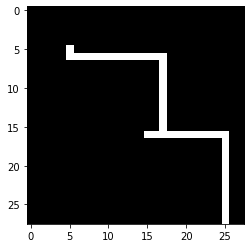

step = 1500: Average Return = 4045.0
step = 1510: loss = 0.28890594840049744
step = 1520: loss = 0.40666961669921875
step = 1530: loss = 0.31379762291908264
step = 1540: loss = 0.13103929162025452
step = 1550: loss = 0.18865466117858887
step = 1560: loss = 0.4695042669773102
step = 1570: loss = 0.22078152000904083
step = 1580: loss = 0.12558212876319885
step = 1590: loss = 0.21024605631828308
step = 1600: loss = 0.40756839513778687
step = 1610: loss = 0.10186044871807098
step = 1620: loss = 0.25492072105407715
step = 1630: loss = 0.05517440661787987
step = 1640: loss = 0.04622695595026016
step = 1650: loss = 0.061095282435417175
step = 1660: loss = 0.25168880820274353
step = 1670: loss = 0.10054682940244675
step = 1680: loss = 0.28818440437316895
step = 1690: loss = 0.21213988959789276
step = 1700: loss = 0.150634765625
step = 1710: loss = 0.08003142476081848
step = 1720: loss = 0.07165596634149551
step = 1730: loss = 0.09202616661787033
step = 1740: loss = 0.11925433576107025
step = 1

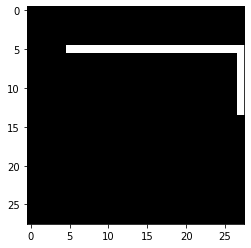

step = 2000: Average Return = 2367.0


In [21]:
returns = []
for _ in range(1000):
    
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % 10 == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % 500 == 0:
    avg_return = compute_avg_return(env, agent.policy, 10)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)